# Pre-processing and Modeling

## Import and Load Data

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import os

from scipy.stats import shapiro
from functools import reduce
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the CSV file into a DataFrame
df = pd.read_csv('../data/data_cleaned.csv')

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month,year,week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2,2010,5
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,2,2010,6
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2,2010,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,2,2010,8
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,3,2010,9


## Feature Engineering

It's worth noting that some information, such as CPI, MarkDowns, Temperature, Fuel Prices, or Unemployment, may not be accessible at the time of prediction. When it comes to time series forecasting, these types of features cannot be used to train the model. However, this project aims to examine retail data with limited history and identify the factors that influence sales, rather than predicting future sales. As a result, there's no need to be concerned about data leakage unlike in typical time series forecasting. Although this project doesn't forecast future sales, analyzing the temporal aspect of the data can still be beneficial in understanding sales dynamics and investigating the connections between sales and other variables.

### Date and Time Features

In [5]:
# Extract the month, year, week from 'Date'
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['week'] = df['Date'].dt.isocalendar().week

### Categorical Features

The dataset included two categorical features, `Type` and `IsHodilay`. Through exploratory data analysis, it was discovered that store type is related to store size, so Ordinal Encoding was utilized for `Type`. `IsHoliday` denotes whether a holiday is observed or not. 

Each holiday has a distinct impact on sales. A new `Holiday` column was created to indicate the name of the holiday on each date. One-Hot encoding was used to generate binary columns for each holiday. 

During the Christmas season, there are significant sales in the weeks leading up to the holiday. In order to account for this, the `WeeksBeforeChristmas` column assigns corresponding values up until four weeks prior to Christmas.

In [14]:
# Assigne the value 1,2,3 to the store types C,B,A
df['Store_Type'] = df['Type'].apply(lambda x:3 if x=='A' else (2 if x =='B' else 1))

# Convert a boolean column with True and False values to integers 1 and 0
df['IsHoliday'] = df['IsHoliday'].astype(int)

In [7]:
# holiday dates for the four holidays
holiday_dates = {
    'Super Bowl': [
        datetime(2010, 2, 12),
        datetime(2011, 2, 11),
        datetime(2012, 2, 10),
    ],
    'Labor Day': [
        datetime(2010, 9, 10),
        datetime(2011, 9, 9),
        datetime(2012, 9, 7),
    ],
    'Thanksgiving': [
        datetime(2010, 11, 26),
        datetime(2011, 11, 25),
    ],
    'Christmas': [
        datetime(2010, 12, 31),
        datetime(2011, 12, 30),
    ]
}

df['Holiday'] = df['Date'].apply(
    lambda x: next((holiday for holiday, dates in holiday_dates.items() if x in dates ), 'No Event'))

In [8]:
# Create Thanksgiving
df['Thanksgiving'] = df['Holiday'].apply(lambda x: 1 if x == 'Thanksgiving' else 0)

In [9]:
# Create WeeksBeforeChristmas
target_dates = [date - pd.DateOffset(weeks=i) for date in holiday_dates['Christmas'] for i in range(1, 6)]

df['WeeksBeforeChristmas'] = df['Date'].map({target_dates[i]: (i+1) % 5 for i in range(len(target_dates))})
df['WeeksBeforeChristmas'] = df['WeeksBeforeChristmas'].fillna(0)

### Lag Features

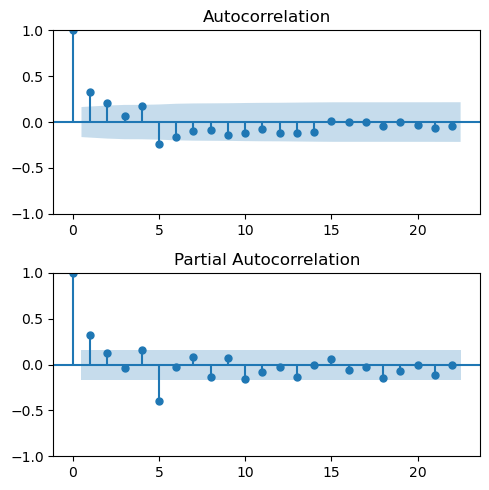

In [11]:
ts = df.groupby('Date')['Weekly_Sales'].mean()

fig, ax = plt.subplots(nrows=2, figsize=[5,5])
plot_acf(ts,ax=ax[0])
plot_pacf(ts,ax=ax[1])
plt.tight_layout()
plt.show()

From the ACF and PACF plot, I created two Lag features, Lag1 and Lag4. Adding Lag1 as a feature enables the model to consider in the previous week's sales. This can capture the dependencies and incorporate the recent sales history as a predictor.  The peak at lag 4 suggests that there may be a cyclical pattern occurring every four weeks. If there is a consistent fluctuation in sales every four weeks due to external factors like monthly promotions, Lag 4 helps the model capture this repeating pattern and its potential impact on the current week's sales.

Note that data is organized hierarchically on a weekly basis. But not every department is consistently available in all stores at all times. Instead of creating lag features at the individual department level, I  generated lag features for the store as a whole. This accounts for the temporal dependencies within each store.

In [12]:
store_sales =df.groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index()
store_sales['Lag1'] = store_sales.groupby('Store')['Weekly_Sales'].shift(1)
store_sales['Lag4'] = store_sales.groupby('Store')['Weekly_Sales'].shift(4)
store_sales= store_sales.drop('Weekly_Sales',axis=1)
df= pd.merge(df, store_sales,how='inner', on=['Date','Store'])

### Window Features

In [16]:
avg_sales = df.groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index()
avg_sales = avg_sales.set_index('Date')
window_sales = avg_sales.groupby('Store')['Weekly_Sales'].rolling(window=4, center=True).agg(['mean'])
df = pd.merge(df, window_sales, how='inner', on=['Date','Store'])
df = df.rename(columns={'mean':'Rolling_4_mean'})

## Imputing Missing Value

Markdown columns are only available from November 2011 onwards and were not present before that. This implies they are not randomly missing. Hence, imputation techniques like mean, median, or mode might not be suitable in this case. 

To gain a better understanding of Markdown columns, a thorough investigation is necessary. Start by examining how different store types impact markdowns. 


In [17]:
# Subset markdowns after Nove,2011

markdown_sales = df[df['Date'] >= pd.to_datetime('2011-11-1')]

In [18]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

is_same_markdown = markdown_sales[~markdown_sales[markdown_cols].isna()].groupby(['Date', 'Store'])[markdown_cols].nunique() == 1

if is_same_markdown.all().all():
    print("All non-missing markdown values are the same for a given date across all departments in each store.")
else:
    print("There are different markdown values for different department in one or more columns.")

All non-missing markdown values are the same for a given date across all departments in each store.


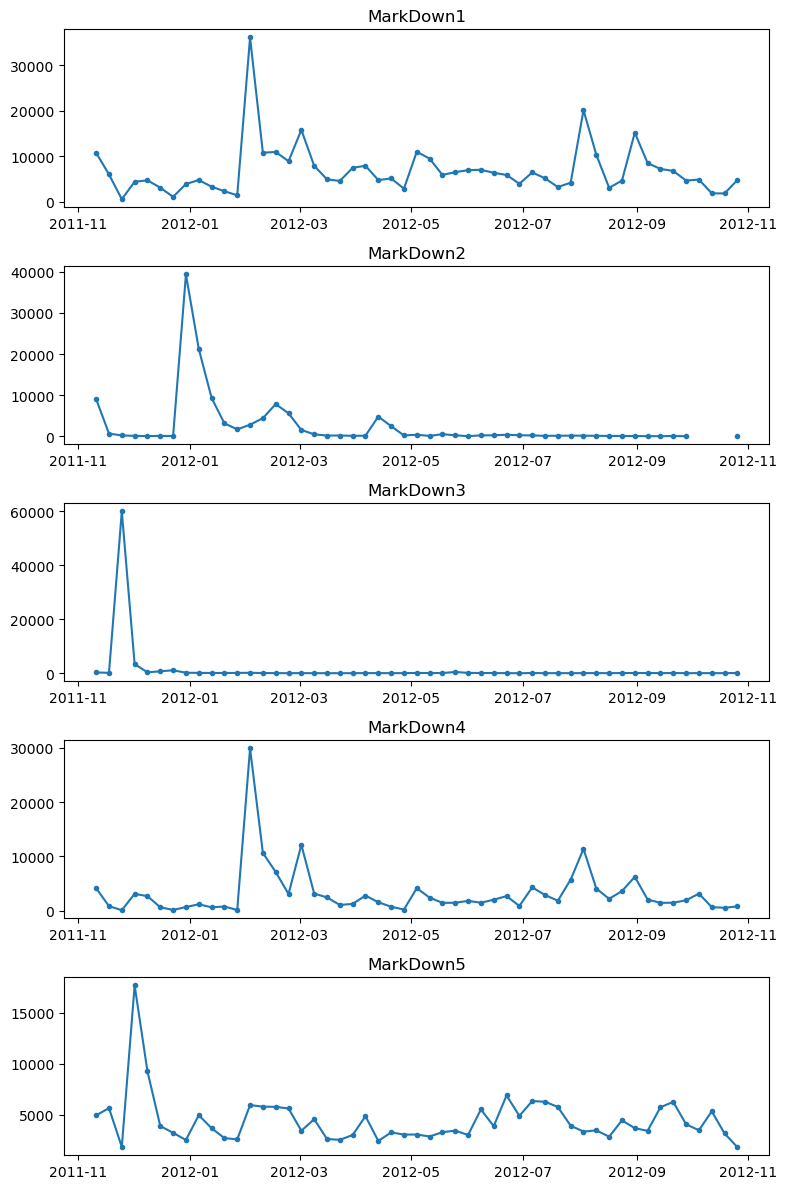

In [80]:
# Keep the first row of each store by the date
unique_markdown_sub = markdown_sales.groupby(['Date', 'Store'])[markdown_cols+['Type']].first().reset_index()


# Average Markdown over time
data = unique_markdown_sub.groupby('Date')[markdown_cols].mean().reset_index()
fig, axs = plt.subplots(figsize=(8, 12), nrows=5)
for i, feature in enumerate(markdown_cols):
    row = i % 5

    x = data['Date']
    y = data[feature]
    mask = np.isnan(y)  
    
    axs[row].plot(x, np.ma.masked_array(y, mask), marker='.', linestyle='-', label=feature)
    
    axs[row].set_title(f"{feature}")

plt.tight_layout()
plt.show()

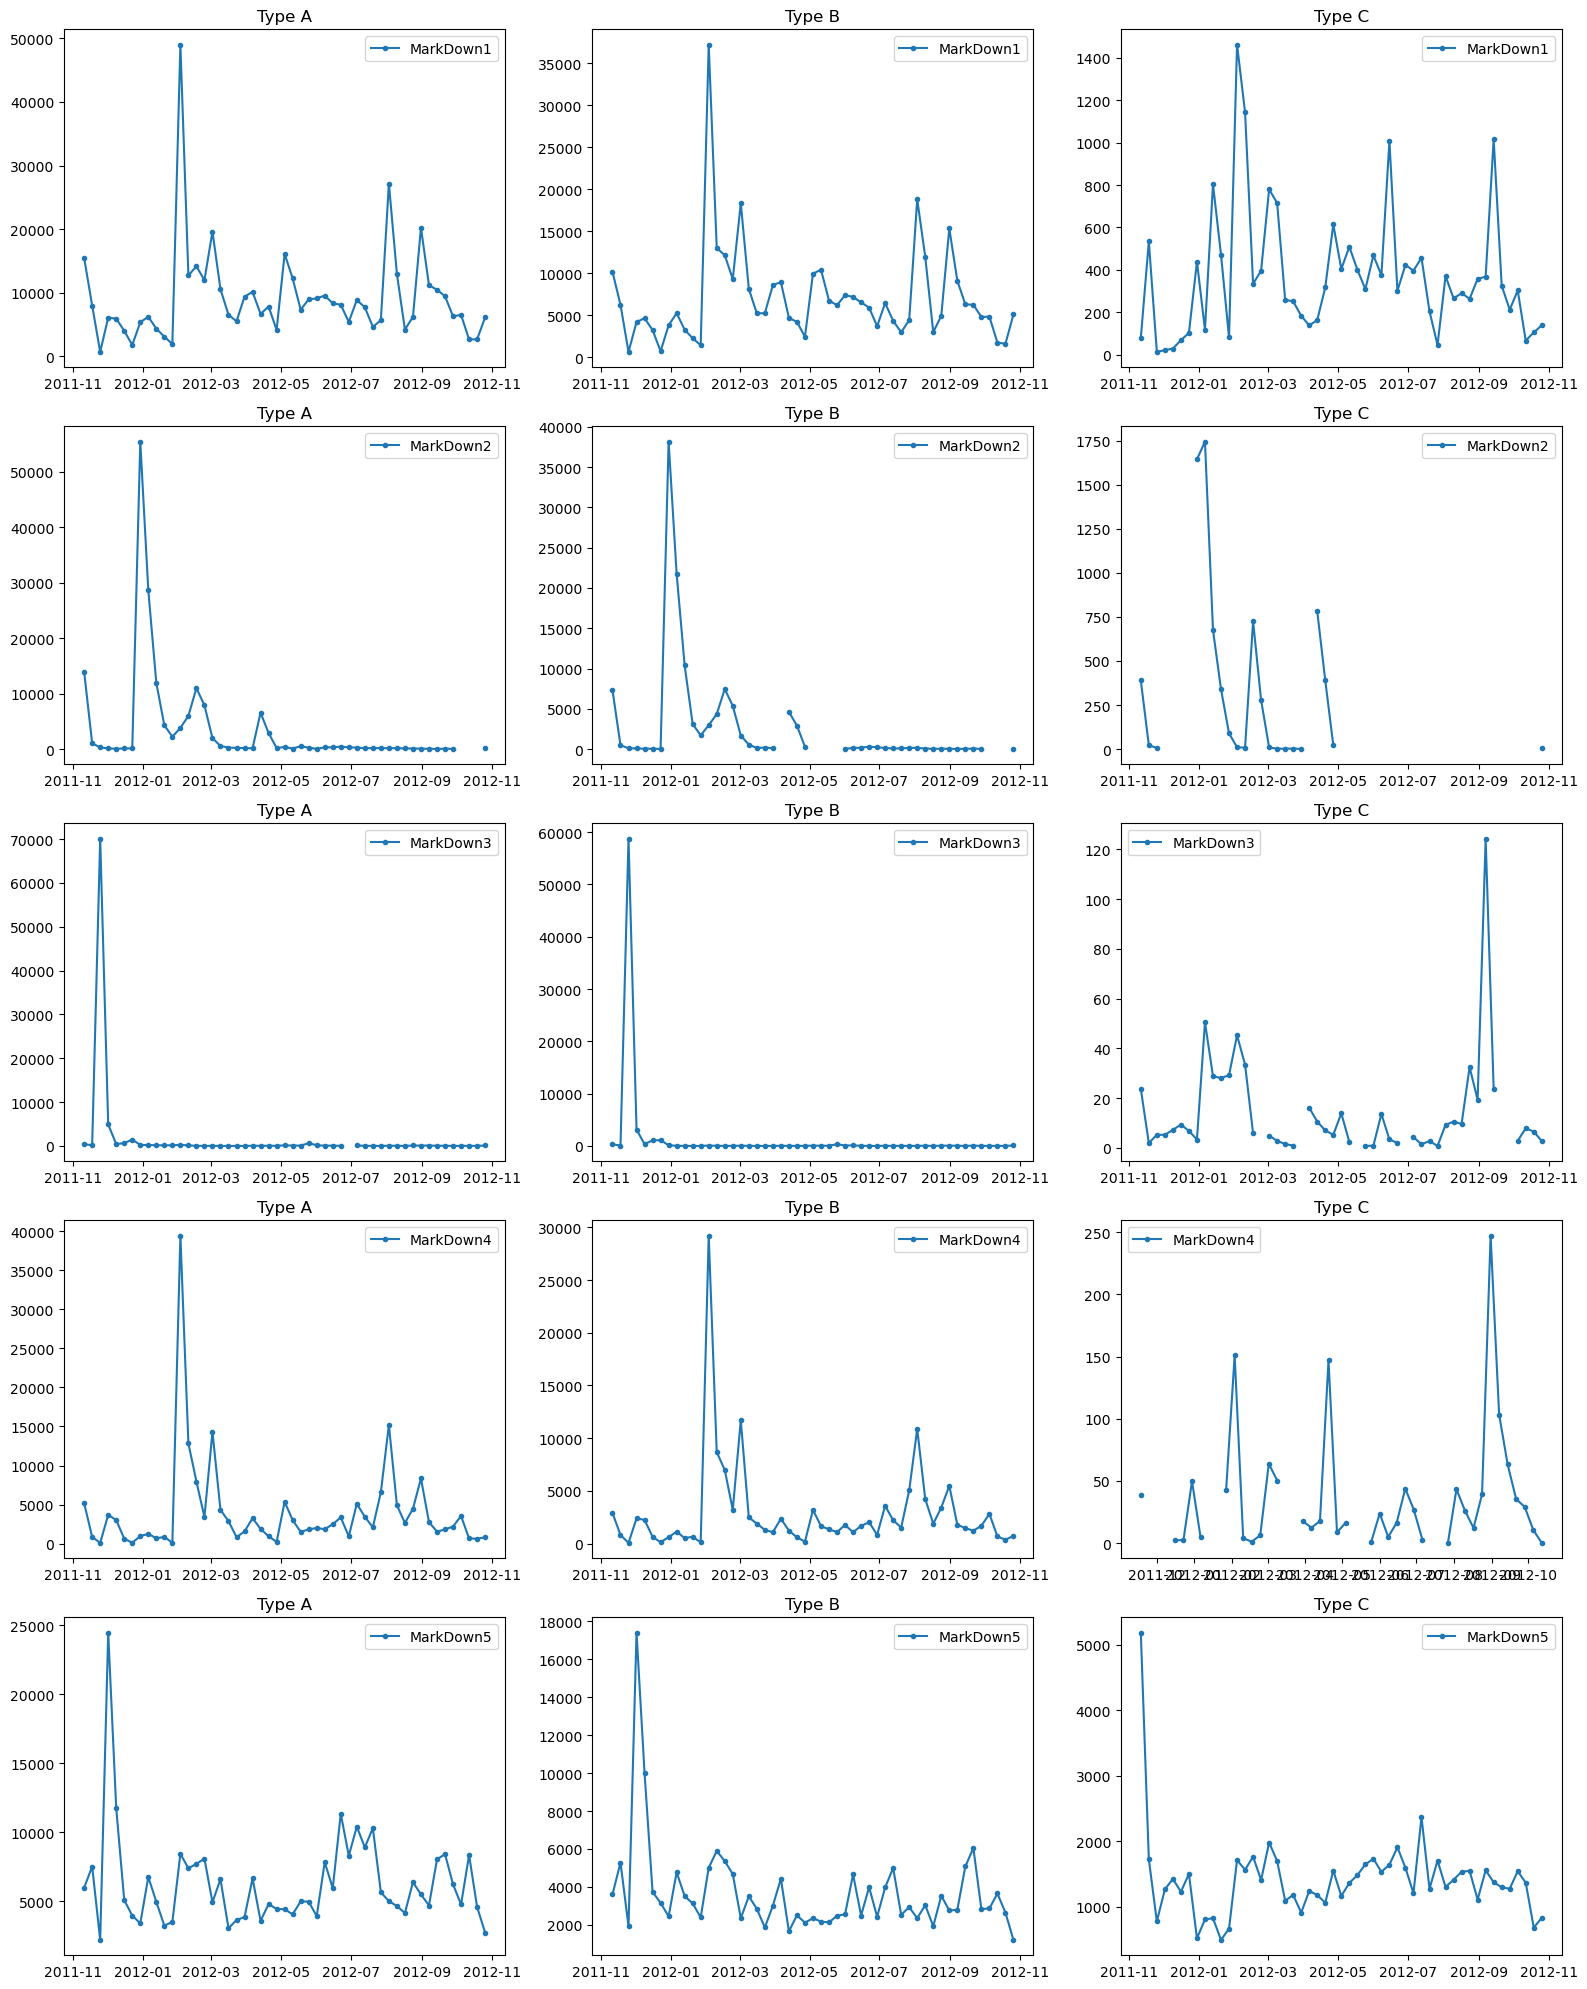

In [81]:
# MarkDowns over Time by Store Type

data = unique_markdown_sub.groupby(['Date', 'Type']).mean().reset_index()

fig, axs = plt.subplots(figsize=(16, 20), nrows=5, ncols=3)
unique_types = data['Type'].unique()

for i, type in enumerate(unique_types):
    col = i % 3
    
    type_data = data[data['Type'] == type]
    for j, feature in enumerate(markdown_cols):
        ax = axs[j % 5, i % 3]
  
        x = type_data['Date']
        y = type_data[feature]
        mask = np.isnan(y)  
        
        ax.plot(x, np.ma.masked_array(y, mask), marker='.', linestyle='-', label=feature)
    
        ax.set_title(f"Type {type}")
        ax.legend()

plt.tight_layout()
plt.show()

In [82]:
# The percentage of missing values by Type
unique_markdown_sub.groupby('Type')[markdown_cols].apply(lambda x: x.isnull().mean() * 100)

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Type,,,,,
A,1.923077,18.557692,5.192308,2.403846,1.923077
B,1.923077,26.357466,11.538462,2.601810,1.923077
C,5.528846,66.586538,33.173077,78.605769,1.923077


In [83]:
unique_markdown_sub[markdown_cols].apply(lambda x: x.isnull().mean() * 100)

MarkDown1     2.564103
MarkDown2    30.042735
MarkDown3    12.564103
MarkDown4    16.025641
MarkDown5     1.923077
dtype: float64

In [84]:
# The number of store in each type
unique_markdown_sub.groupby('Type')['Store'].nunique()

Type
A    20
B    17
C     8
Name: Store, dtype: int64

In [85]:
unique_markdown_sub.groupby('Type')[markdown_cols].describe().T

Type                         A              B             C
MarkDown1 count    1020.000000     867.000000    393.000000
          mean     9181.400971    7056.083829    376.808321
          std      8693.541968    7857.878874    458.560289
          min        32.500000      35.940000      0.270000
          25%      4375.317500    2609.150000     73.930000
          50%      6965.090000    5051.870000    246.980000
          75%     10861.892500    8488.495000    470.510000
          max     78124.500000   88646.760000   3297.480000
MarkDown2 count     847.000000     651.000000    139.000000
          mean     3838.587355    3012.755392    409.059568
          std     10483.823349    8415.548443    656.279096
          min      -265.760000     -10.980000      0.020000
          25%        63.050000      28.425000      4.235000
          50%       232.430000     152.910000     27.600000
          75%      2571.195000    2115.930000    581.075000
          max     97740.990000  104519.540000   2765.450000
MarkDown3 count     986.000000     782.000000    278.000000
          mean     1655.153753    1439.163235     15.798669
          std     10324.020602    9521.683943     29.040674
          min       -29.100000       0.000000     -0.870000
          25%         9.365000       3.582500      2.137500
          50%        44.795000      15.745000      4.945000
          75%       158.655000      71.415000     16.490000
          max    109030.750000  141630.610000    251.310000
MarkDown4 count    1015.000000     861.000000     89.000000
          mean     3935.354148    2894.819257     59.072022
          std      6874.461128    5536.642468     93.278623
          min         3.000000       2.000000      0.220000
          25%       744.165000     442.390000      4.920000
          50%      1799.430000    1239.040000     25.600000
          75%      4076.390000    2976.500000     64.470000
          max     67474.850000   57815.430000    615.930000
MarkDown5 count    1020.000000     867.000000    408.000000
          mean     6297.650637    3664.139988   1417.926029
          std      7457.097828    3955.784632   1591.750342
          min       492.360000     135.160000    153.040000
          25%      3220.962500    1651.275000    750.927500
          50%      4655.310000    2747.360000   1173.565000
          75%      7105.387500    4463.065000   1713.897500
          max    108519.280000   57029.780000  27754.230000

* The stores categorized as Type A and B exhibit a similar pattern over time, with the majority of markdown columns having low percentages of missing values. 
* On the other hand, Type C stores, despite being the smallest in size, have the highest percentage of missing values, Also, the plot indicates a different pattern compared to the other store types.
* Additionally, there are differences in the distribution of markdown values among store types, with A and B stores having wider ranges and higher mean and median values than C stores. 


The fact that 'MarkDown' values are only available after Nov 2011 poses an interesting challenge. Here are possible strategies to handle this.

1. **Fill missing values with zero and flag missingness with a binary column**

It's important to note that a missing 'MarkDown' value doesn't necessarily mean that there was no markdown event during that week. To account for this, additional features were added to indicate whether the 'MarkDown' values were originally missing. This would enable the model to consider the possibility of missing data that isn't random.

2. **Impute missing values**  

During the exploratory data analysis, it was observed that the average markdown pattern over time was related to specific holidays. Based on this insight, an effective strategy for imputing missing MarkDown values for each store could be to utilize MarkDown during the corresponding week. This approach would preserve the temporal patterns in the MarkDown data.

3. **Drop 'MarkDown' features** 


#### Fill missing values with zero and flag missingness with a binary column

In [20]:
df1 = df.copy()
for col in markdown_cols:
    df1[col + '_missing'] = df1[col].notnull().astype(int)
    df1[col].fillna(0, inplace=True)

#### Impute missing values

Missing values of Type A and Type B stores are imputed using interpolation at store level. However, Type C stores aggregate the values for each MarkDown column and then perform the interpolation.

In [21]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
unique_markdown = df.groupby(['Date', 'Store'])[markdown_cols+['Type']].first().reset_index()
unique_markdown['week'] = unique_markdown['Date'].dt.isocalendar().week

In [22]:
# Filter the data for dates after November 2011
# Create a separate subset for each type

df_AB = unique_markdown[unique_markdown['Type'].isin(['A', 'B'])]
df_C = unique_markdown[unique_markdown['Type']=='C']

In [26]:
# Interpolate missing values for stores categorized as Type A and B
imputed_AB = df_AB[df_AB['Date'] > pd.to_datetime('2011-11-1')]
imputed_AB.sort_values('week', inplace=True)

interpolated = imputed_AB.groupby('Store')[markdown_cols].apply(lambda group: group.interpolate(method='linear'))

imputed_AB=imputed_AB.sort_values(by=['Store','week']).reset_index(drop=True)
interpolated = interpolated.reset_index(drop=True)

imputed_AB[markdown_cols] = interpolated

In [27]:
# Markdowns were aggregated
# Interpolate missing values for stores categorized as Type C

imputed_C = df_C[df_C['Date'] > pd.to_datetime('2011-11-1')]
imputed_C_agg = df_C.groupby('week')[markdown_cols].mean().reset_index()
imputed_C_agg[markdown_cols] = imputed_C_agg[markdown_cols].interpolate(method='linear')
merged_C = pd.merge(imputed_C,imputed_C_agg, how='left', on = ['week'],suffixes=('', '_avg'))
for col in markdown_cols:
    merged_C[col].fillna(merged_C[col + '_avg'], inplace=True)
merged_C.drop(columns=[col + '_avg' for col in markdown_cols], inplace=True)

In [29]:
# Complete data with unique markdown values 

fiiled_subset = pd.concat([imputed_AB,merged_C],axis=0,ignore_index=True)
fiiled_subset.sort_values(by=['Date','Store'],inplace=True)

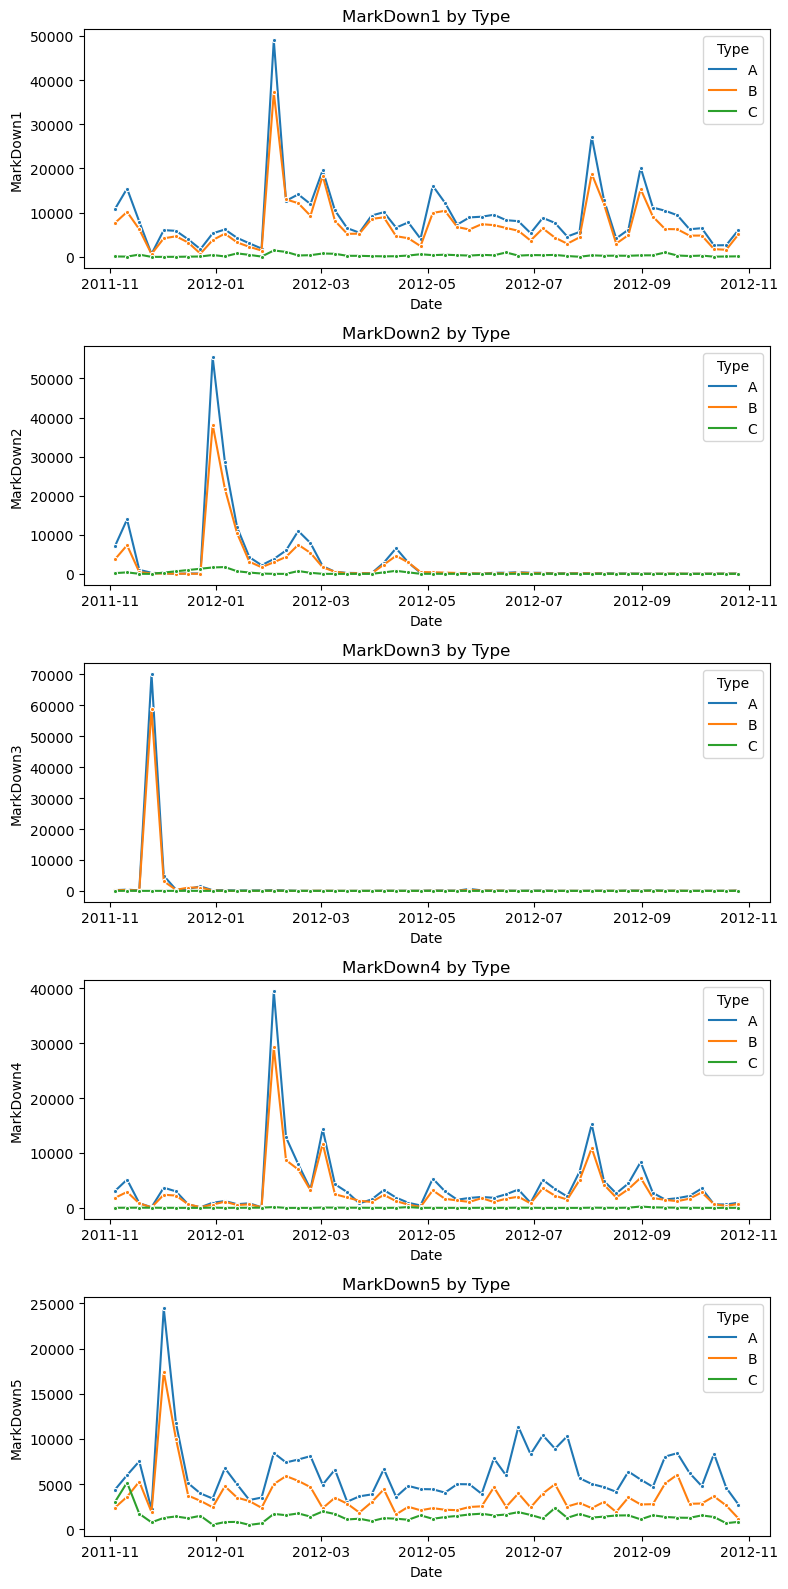

In [30]:
data = fiiled_subset.groupby(['Date','Type'])[markdown_cols].mean().reset_index()

fig, axs = plt.subplots(5, 1, figsize=(8, 16))

for i, col in enumerate(markdown_cols):
    sns.lineplot(x='Date', y=col, hue='Type', data=data, ax=axs[i], marker='.')
    
    axs[i].set_title(f'{col} by Type')

plt.tight_layout()
plt.show()

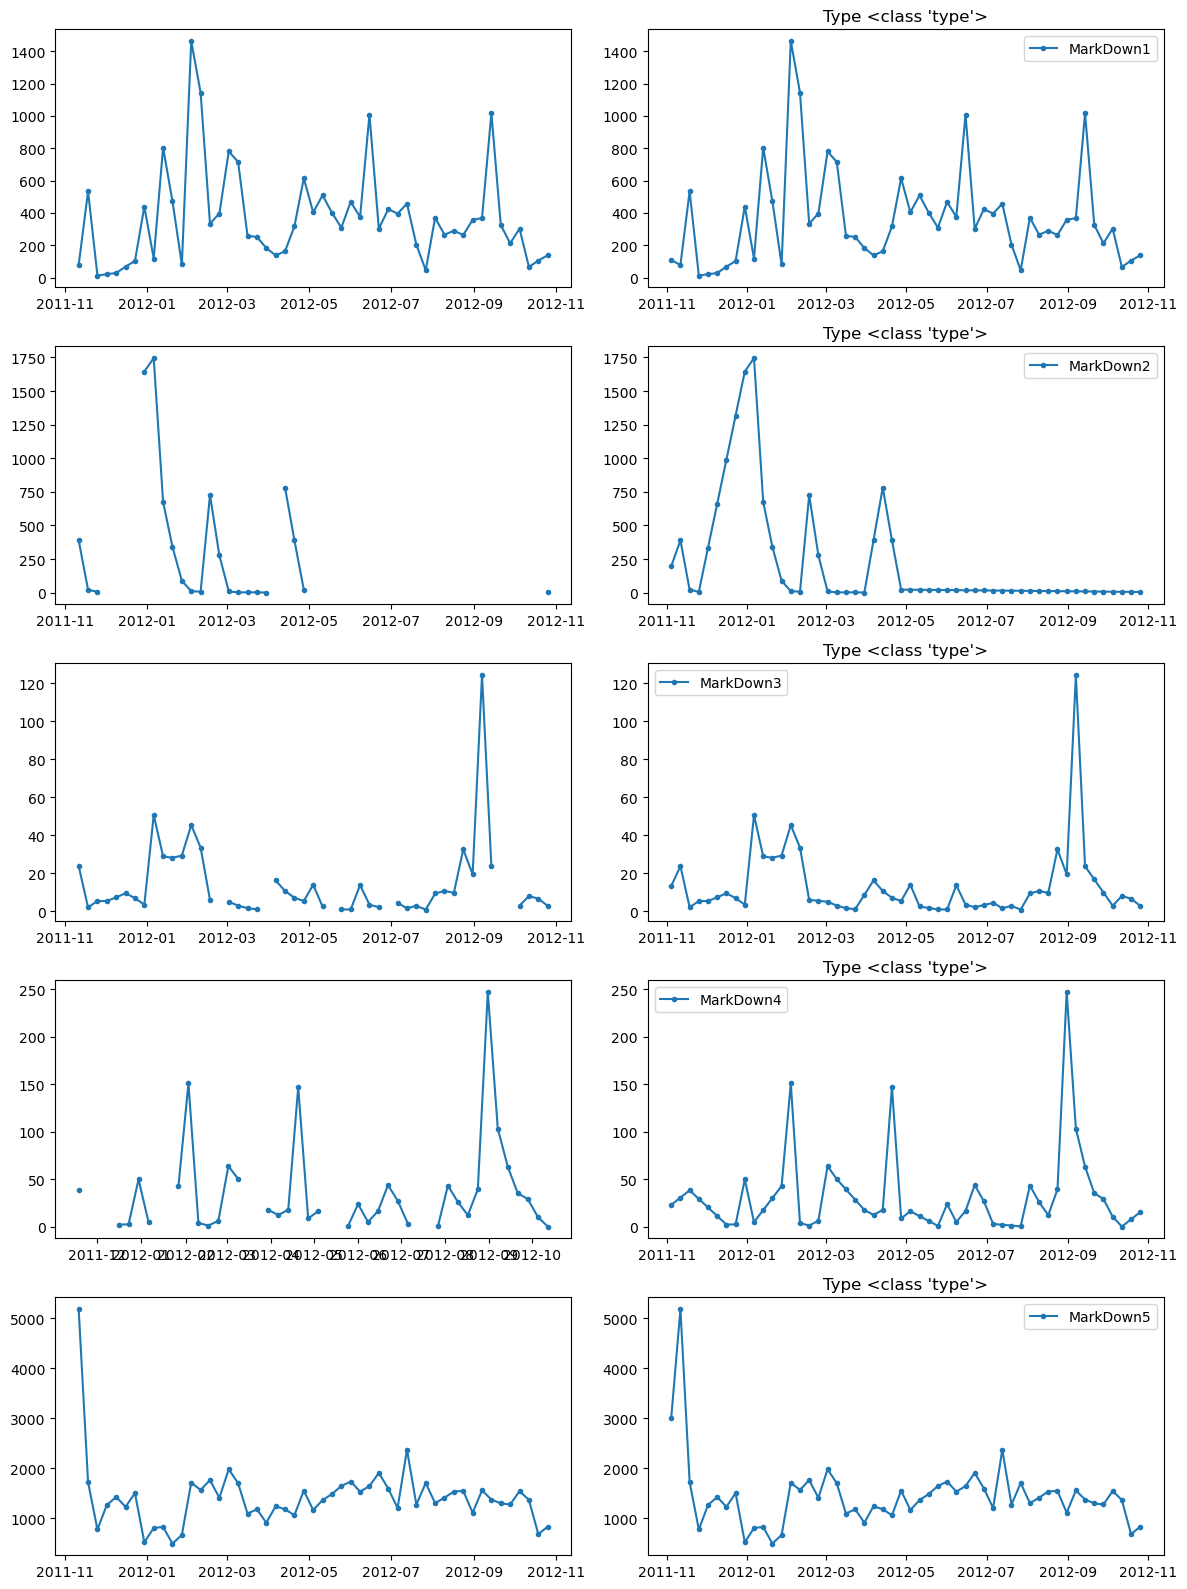

In [31]:
# MarkDowns after imputation

data = fiiled_subset.groupby(['Date', 'Type']).mean().reset_index()
data1 = unique_markdown_sub.groupby(['Date', 'Type']).mean().reset_index()

fig, axs = plt.subplots(figsize=(12, 16), nrows=5, ncols=2)


for j, feature in enumerate(markdown_cols):
    ax = axs[j % 5,1]
    ax1 = axs[j % 5,0]  
    x = data[data['Type']=='C']['Date']
    y =  data[data['Type']=='C'][feature] 
    y1 = data1[data1['Type']=='C'][feature]
    ax.plot(x, y, marker='.', linestyle='-', label=feature)   
    ax1.plot(x, y1, marker='.', linestyle='-', label=feature)  
    ax.set_title(f"Type {type}")
    ax.legend()
   
plt.tight_layout()
plt.show()

Assuming that the patterns in 'MarkDown' remain consistent, the patterns observed after November 2011 can also be applied to the period before November 2011.However, if the 'MarkDown' strategies of the store have significantly changed over time, the imputed values may not be reliable.  In this case, it would be more reasonable to follow the first strategy employed prior to November 2011.

In [32]:
# Merge 'df' with 'fiiled_subset' on 'Store', week' and 'Type'

merged_data = pd.merge(df, fiiled_subset, how='left', on=['Store', 'week', 'Type'], suffixes=('', '_sub'))
for col in markdown_cols:
    merged_data[col].fillna(merged_data[col + '_sub'], inplace=True)

In [33]:
# df2 = Fill missing values in 'df' with those from 'fiiled_subset'

df2 = merged_data[merged_data.columns.drop(list(merged_data.filter(regex='_sub')))]

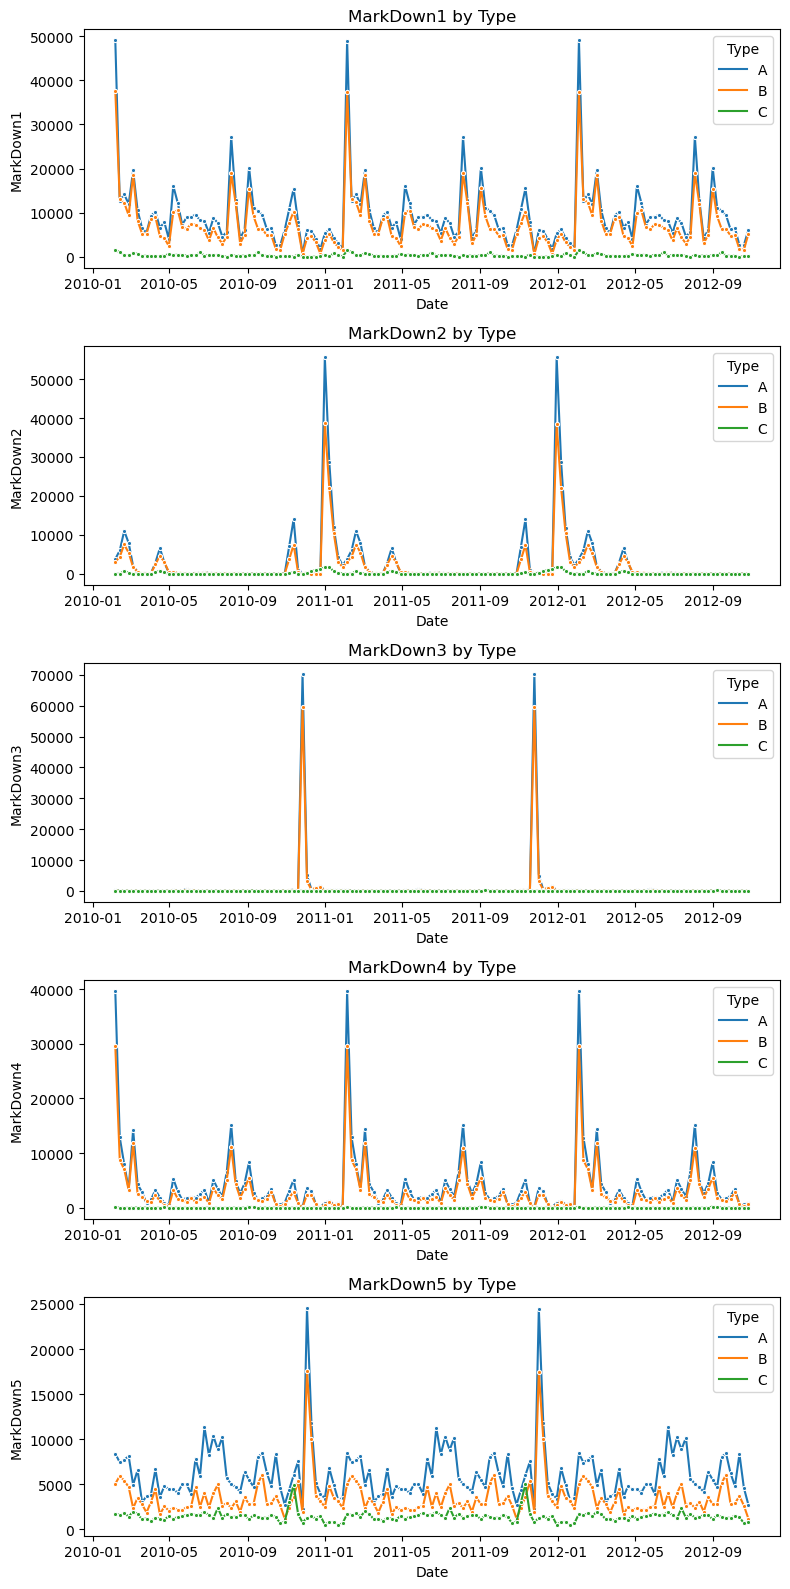

In [35]:
# plot Markdowns after imputation

data = df2.groupby(['Date','Type'])[markdown_cols].mean().reset_index()

fig, axs = plt.subplots(5, 1, figsize=(8, 16))

for i, col in enumerate(markdown_cols):
    sns.lineplot(x='Date', y=col, hue='Type', data=data, ax=axs[i], marker='.')
    
    axs[i].set_title(f'{col} by Type')

plt.tight_layout()
plt.show()

In [36]:
# df3 filling with 0 only before Nov, 2011

df3 = df[df['Date'] < pd.to_datetime('2011-11-1')]

# Merge markdown_sales with 'fiiled_subset' on 'Store', week','Type' and 'Date'
merged_subset = pd.merge(markdown_sales, fiiled_subset, how='left', on=['Store', 'week', 'Type','Date'], suffixes=('', '_sub'))
for col in markdown_cols:
    merged_data[col].fillna(merged_data[col + '_sub'], inplace=True)
    
merged_subset.drop(columns=[col + '_sub' for col in markdown_cols], inplace=True)

df3 = pd.concat([df3, merged_subset], ignore_index=True)

for col in markdown_cols:
    df3[col + '_missing'] = df3[col].notnull().astype(int)
    df3[col].fillna(0, inplace=True)

#### Drop 'MarkDown' features

In [37]:
df4 = df.drop(columns=markdown_cols)

In [38]:
df2.to_csv('df_imputed.csv',index=False)

## Train-Test Split

When dealing with time series data, it is crucial to maintain the chronological order while splitting it. Rather than dividing the data using a ratio that could potentially cause train-test contamination, I opted for a specific time point to include all observations before that point in the same set. The training set consists of 80% of the total weeks in the data. 


In [50]:
def ts_split(df,ratio,target):
    df = df.drop(columns=['Holiday', 'Type']).dropna()
    df['week'] = df['week'].astype(int)
    
    train_week_ratio = ratio
    split_date = int(df['Date'].nunique() * train_week_ratio)
    condition = df['Date'] > df['Date'].unique()[split_date-1]
    train =df[~condition].set_index('Date')
    test = df[condition].set_index('Date')
    X_train = train.drop(columns=target)
    y_train = train[target]

    X_test = test.drop(columns=target)
    y_test = test[target]
    return X_train, y_train, X_test, y_test

## Baseline Model

In [49]:
def preprocess_data(df):
    df = df.drop(columns=['Holiday', 'Type']).set_index('Date').dropna()
    df['week'] = df['week'].astype(int)
    return df

In [46]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [47]:
def WMAE(model,X_test, y_test):
    weights = X_test.IsHoliday.apply(lambda x: 5 if x else 1)
    y_pred = model.predict(X_test)
    return np.round(np.sum(weights*abs(y_test-y_pred))/(np.sum(weights)), 2)

In [52]:
dfs = ['df1','df3','df4','df2']

for dataset in dfs:
    df = eval(dataset)
    
    X_train,y_train, X_test, y_test = ts_split(df,0.8,'Weekly_Sales')

    
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    decision_tree_model = DecisionTreeRegressor(random_state=42)
    decision_tree_model.fit(X_train, y_train)
    
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    
    gradient_boosting_model = GradientBoostingRegressor(random_state=42)
    gradient_boosting_model.fit(X_train, y_train)
    
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    
    catboost_model = CatBoostRegressor(verbose=False)
    catboost_model.fit(X_train, y_train)
    
    linear_rmse = evaluate_model(linear_model, X_test, y_test)
    decision_tree_rmse = evaluate_model(decision_tree_model, X_test, y_test)
    rf_rmse = evaluate_model(rf_model, X_test, y_test)
    gradient_boosting_rmse = evaluate_model(gradient_boosting_model, X_test, y_test)
    xgb_rmse = evaluate_model(xgb_model, X_test, y_test)
    catboost_rmse = evaluate_model(catboost_model, X_test, y_test)
    
    print(f"Results for {dataset}:")
    print("Linear Regression:", linear_rmse)
    print("Decision Tree:", decision_tree_rmse)
    print("Random Forest:", rf_rmse)
    print("XGBoost:", xgb_rmse)
    print("CatBoost:", catboost_rmse)
    print("Gradinet Boosting:", gradient_boosting_rmse)
    print()
    

Results for df1:
Linear Regression: 20609.103234463546
Decision Tree: 5865.574592617104
Random Forest: 3704.435406817967
XGBoost: 5127.048232507814
CatBoost: 4974.671878280174
Gradinet Boosting: 9843.293357525292

Results for df3:
Linear Regression: 20609.10323446356
Decision Tree: 5847.749056785415
Random Forest: 3694.0039703951957
XGBoost: 5127.048232507814
CatBoost: 4941.194399870658
Gradinet Boosting: 9843.29335752529

Results for df4:
Linear Regression: 20604.065261151805
Decision Tree: 5632.025455162726
Random Forest: 3668.209466120381
XGBoost: 4923.960827265063
CatBoost: 5053.800840089617
Gradinet Boosting: 9843.293357525292

Results for df2:
Linear Regression: 20605.864188304804
Decision Tree: 5363.546235289568
Random Forest: 3554.7943723054696
XGBoost: 5008.805343535645
CatBoost: 5110.219046026968
Gradinet Boosting: 9732.429328676764



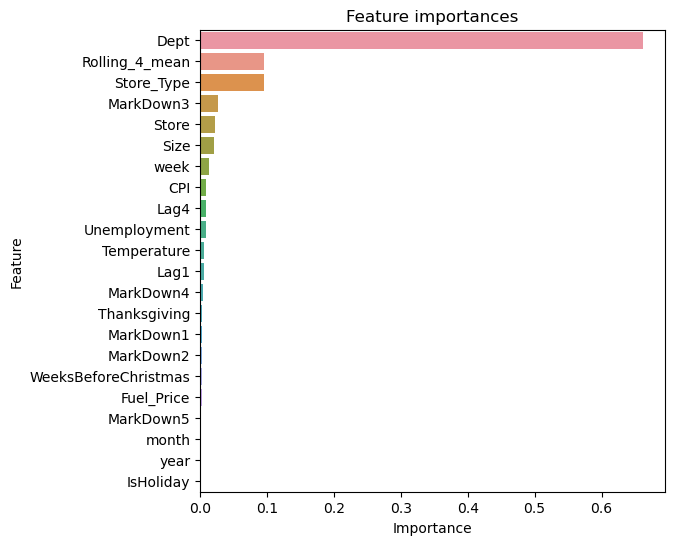

In [53]:
importances = decision_tree_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', orient='h')
plt.title('Feature importances')
plt.show()

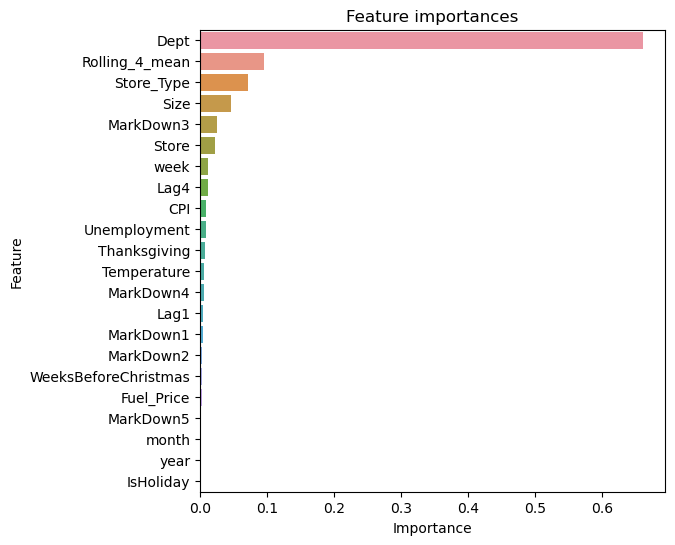

In [54]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', orient='h')
plt.title('Feature importances')
plt.show()

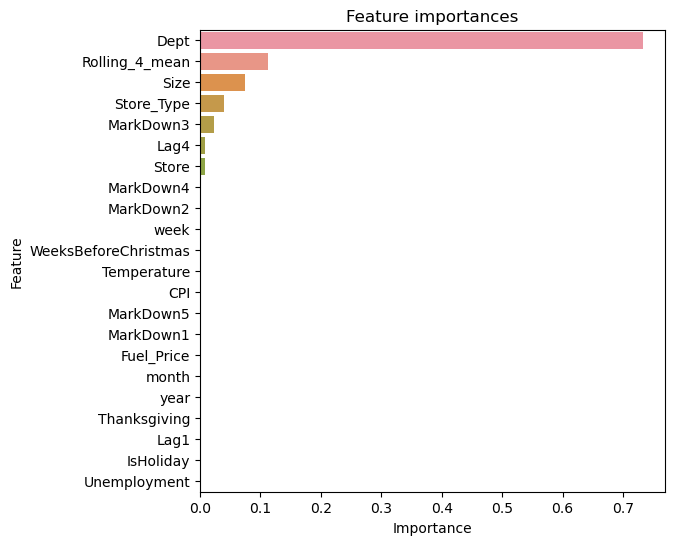

In [55]:
importances = gradient_boosting_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', orient='h')
plt.title('Feature importances')
plt.show()

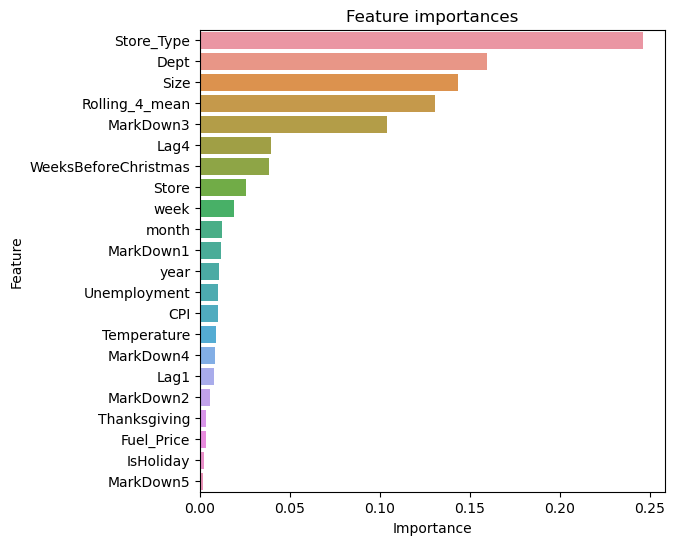

In [56]:
importances = xgb_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', orient='h')
plt.title('Feature importances')
plt.show()

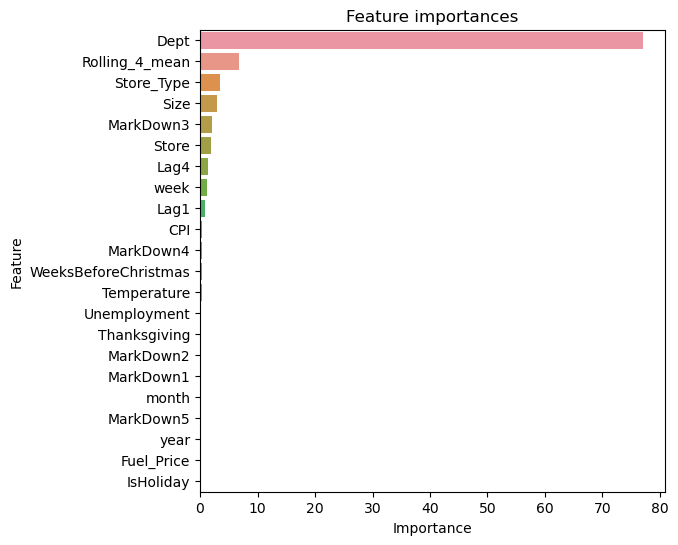

In [57]:
importances = catboost_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', orient='h')
plt.title('Feature importances')
plt.show()

In [58]:
y_pred = rf_model.predict(X_test)
X_test_with_y = X_test.assign(Weekly_Sales=y_test, Weekly_Sales_pred=y_pred)

data = X_test_with_y.groupby('Date')[['Weekly_Sales_pred']].mean().reset_index()
data1 = df.groupby('Date')['Weekly_Sales'].mean().reset_index()
# Convert the 'Date' column to datetime format
data1['Date'] = pd.to_datetime(data1['Date'], format='%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

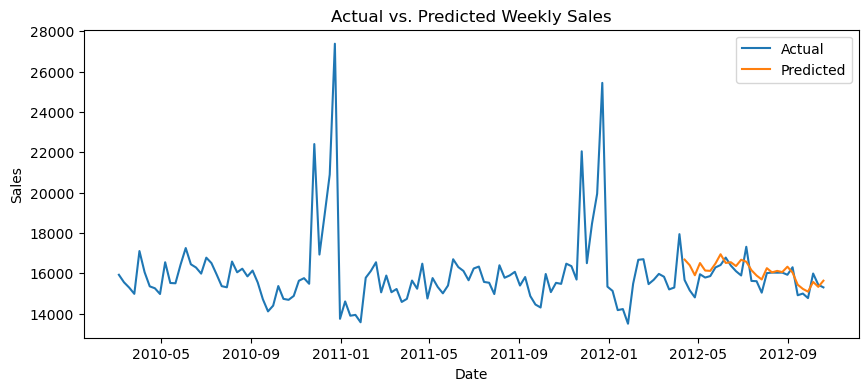

In [56]:
plt.figure(figsize=(10, 4))
# Plotting the actual values (y_test)
sns.lineplot(data=data1,x='Date',y = 'Weekly_Sales' ,label='Actual')

# Plotting the predicted values (y_pred)
sns.lineplot(data=data, x='Date',y = 'Weekly_Sales_pred', label='Predicted')


# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Weekly Sales')

# Display the plot

plt.show()


## Model Selection

### Randon Forest

In [94]:
df_final = preprocess_data(df2)
X = df_final.drop(columns=['Weekly_Sales'])
y = df_final['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test), rf_model.get_params()

(3121.3510609352165,
 {'bootstrap': True,
  'ccp_alpha': 0.0,
  'criterion': 'squared_error',
  'max_depth': None,
  'max_features': 1.0,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 100,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False})

### Hyperparameter Tuning

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 75, 100, 150],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, 
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

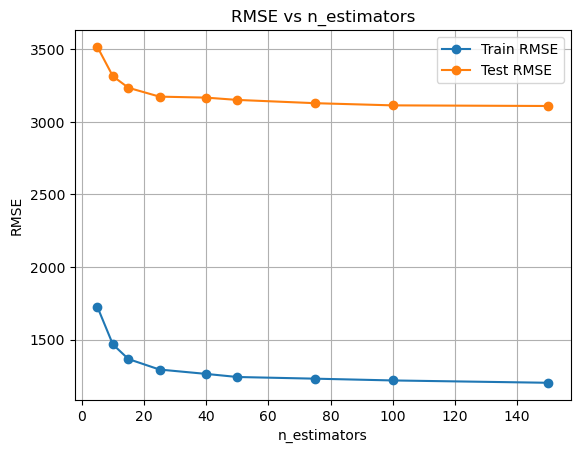

In [99]:
n_estimators = [5, 10, 15, 25, 40, 50, 75, 100, 150]
train_rmse = []
test_rmse = []

for n in n_estimators:
    
    model = RandomForestRegressor(n_estimators=n, max_depth=40, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    y_test_pred = model.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

plt.plot(n_estimators, train_rmse, marker='o', label='Train RMSE')
plt.plot(n_estimators, test_rmse, marker='o', label='Test RMSE')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs n_estimators')
plt.legend()
plt.grid(True)
plt.show()

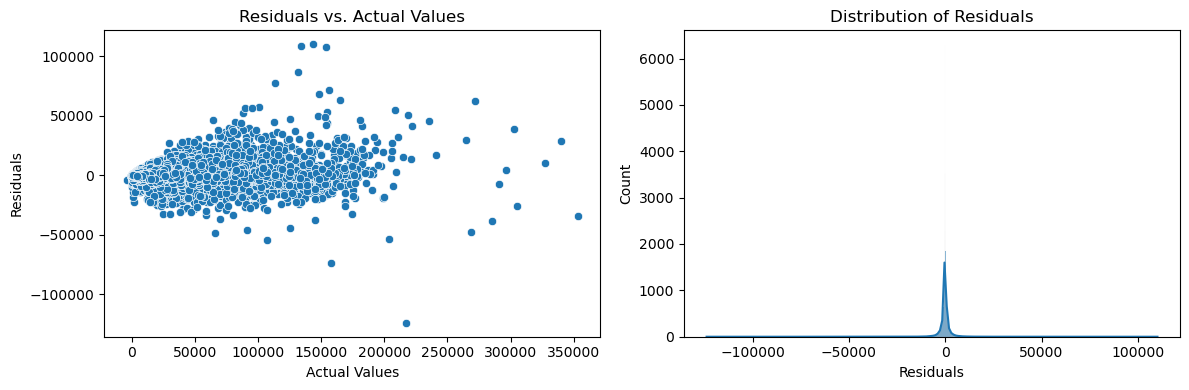

In [102]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=40, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=residuals)
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')


plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')


plt.tight_layout()
plt.show()

## XGBoost

In [96]:
import time

In [ ]:
params = { 
    'max_depth': [3,7,10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500, 1000],
    'colsample_bytree': [0.7, 0.8,1.0],
    'subsample' :[0.8, 0.9, 1.0]}

xgbr = xgb.XGBRegressor(random_state = 45)

grid_search = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
    
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


In [121]:
start_time=time.time()
xgb_model = xgb.XGBRegressor(learning_rate=0.05 ,n_estimators=1000,max_depth=10, colsample_bytree=0.7, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
end_time = time.time()
evaluate_model(xgb_model, X_test, y_test), end_time-start_time

(2747.750824848074, 109.09556102752686)

In [122]:
evaluate_model(xgb_model, X_train, y_train)

1668.1860858001967

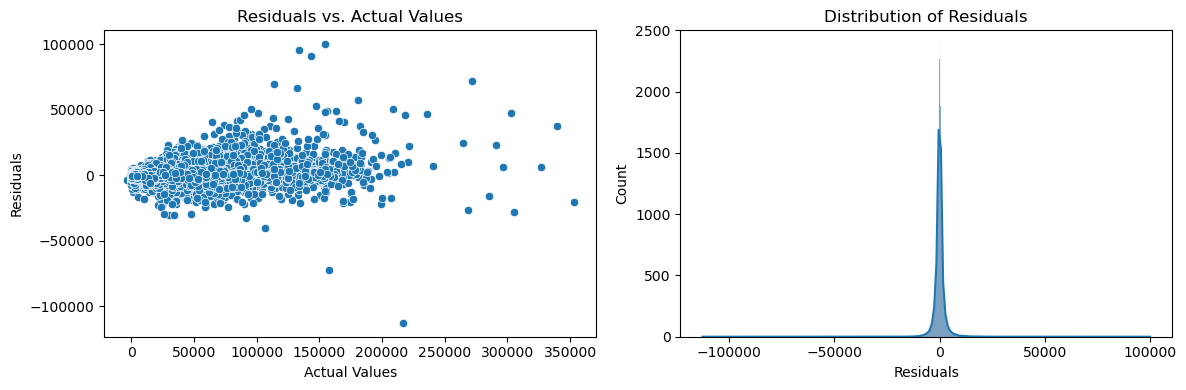

In [123]:
y_pred = xgb_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=residuals)
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')


plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')


plt.tight_layout()
plt.show()

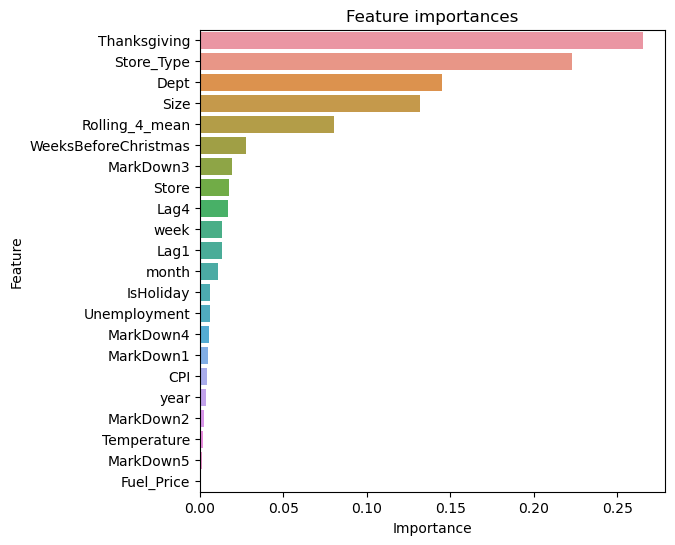

In [125]:
importances = xgb_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', orient='h')
plt.title('Feature importances')
plt.show()